In [1]:
from keras.initializers import Initializer
from sklearn.cluster import KMeans

from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# kmeans layer
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [3]:
## RBF layer 
class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## 生成数据

In [4]:
## create dataset
# reference https://zhuanlan.zhihu.com/p/36982945
def test_data(sample_number = 1000):
    #随机从高斯分布中生成两个数据集
    mean0=[2,7]
    cov=np.mat([[1,0],[0,2]])
    data1=np.random.multivariate_normal(mean0,cov,sample_number)

    mean1=[6,3]
    cov=np.mat([[1,0],[0,2]])
    data2=np.random.multivariate_normal(mean1,cov,sample_number)
    
    y1 = np.zeros((sample_number,1))#第一类，标签为0
    y2 = np.ones((sample_number,1))#第二类类，标签为1
    
    train_data = np.vstack((data1,data2))
    train_label = np.vstack((y1,y2))
    
    shuffle_idx = np.arange(sample_number*2)
    np.random.shuffle(shuffle_idx)
    
    train_data = train_data[shuffle_idx]
    train_label = train_label[shuffle_idx]
    return train_data,train_label

In [5]:
samples_num = 1000
train_data,train_label = test_data(samples_num)

## 生成模型

In [6]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersKMeans(train_data),
                    betas=2.0,
                    input_shape=(2,))
model.add(rbflayer)
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model.compile(loss=binary_crossentropy,optimizer=Adam(),metrics=['accuracy'])

In [8]:
model.fit(train_data,train_label,epochs=1000)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1000
2000/2000 [==============================] - 1s 353us/step - loss: 4.4657 - accuracy: 0.5140
Epoch 2/1000
2000/2000 [==============================] - 0s 62us/step - loss: 4.0193 - accuracy: 0.5320
Epoch 3/1000
2000/2000 [==============================] - 0s 64us/step - loss: 3.5829 - accuracy: 0.5500
Epoch 4/1000
2000/2000 [==============================] - 0s 61us/step - loss: 2.9083 - accuracy: 0.5600
Epoch 5/1000
2000/2000 [==============================] - 0s 60us/step - loss: 2.2388 - accuracy: 0.5715
Epoch 6/1000
2000/2000 [==============================] - 0s 65us/step - loss: 1.9430 - accuracy: 0.5795
Epoch 7/1000
2000/2000 [==============================] - 0s 60us/step - loss: 1.7740 - accuracy: 0.5820
Epoch 8/1000
2000/2000 [==============================] - 0s 61us/step - loss: 1.6486 - accuracy: 0.5840
Epoch 9/1000
2000/2000 [==============================] - 0s 60u

2000/2000 [==============================] - 0s 63us/step - loss: 0.0387 - accuracy: 0.1835
Epoch 74/1000
2000/2000 [==============================] - 0s 61us/step - loss: 0.0381 - accuracy: 0.1800
Epoch 75/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0383 - accuracy: 0.1810
Epoch 76/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0381 - accuracy: 0.1815
Epoch 77/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0378 - accuracy: 0.1820
Epoch 78/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0379 - accuracy: 0.1830
Epoch 79/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0377 - accuracy: 0.1775
Epoch 80/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0378 - accuracy: 0.1850
Epoch 81/1000
2000/2000 [==============================] - 0s 61us/step - loss: 0.0391 - accuracy: 0.1775
Epoch 82/1000
2000/2000 [==============================] - 0

Epoch 150/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0305 - accuracy: 0.1960
Epoch 151/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0298 - accuracy: 0.1995
Epoch 152/1000
2000/2000 [==============================] - 0s 58us/step - loss: 0.0302 - accuracy: 0.1975
Epoch 153/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0303 - accuracy: 0.1995
Epoch 154/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0301 - accuracy: 0.1995
Epoch 155/1000
2000/2000 [==============================] - 0s 60us/step - loss: 0.0302 - accuracy: 0.1970
Epoch 156/1000
2000/2000 [==============================] - 0s 59us/step - loss: 0.0318 - accuracy: 0.1960
Epoch 157/1000
2000/2000 [==============================] - 0s 58us/step - loss: 0.0298 - accuracy: 0.1980
Epoch 158/1000
2000/2000 [==============================] - 0s 61us/step - loss: 0.0301 - accuracy: 0.1975
Epoch 159/1000
2000/2000 [===========

2000/2000 [==============================] - 0s 72us/step - loss: 0.0298 - accuracy: 0.1785
Epoch 227/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0292 - accuracy: 0.1780
Epoch 228/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0293 - accuracy: 0.1740
Epoch 229/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0292 - accuracy: 0.1780
Epoch 230/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0293 - accuracy: 0.1725
Epoch 231/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0293 - accuracy: 0.1775
Epoch 232/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0292 - accuracy: 0.1775
Epoch 233/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0293 - accuracy: 0.1765
Epoch 234/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0295 - accuracy: 0.1730
Epoch 235/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 71us/step - loss: 0.0290 - accuracy: 0.1805
Epoch 303/1000
2000/2000 [==============================] - 0s 74us/step - loss: 0.0292 - accuracy: 0.1795
Epoch 304/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0289 - accuracy: 0.1890
Epoch 305/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0293 - accuracy: 0.1725
Epoch 306/1000
2000/2000 [==============================] - 0s 74us/step - loss: 0.0294 - accuracy: 0.1775
Epoch 307/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0292 - accuracy: 0.1795
Epoch 308/1000
2000/2000 [==============================] - 0s 74us/step - loss: 0.0290 - accuracy: 0.1885
Epoch 309/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0287 - accuracy: 0.1790
Epoch 310/1000
2000/2000 [==============================] - 0s 78us/step - loss: 0.0287 - accuracy: 0.1845
Epoch 311/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 73us/step - loss: 0.0286 - accuracy: 0.1820
Epoch 379/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0293 - accuracy: 0.1930
Epoch 380/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0287 - accuracy: 0.1910
Epoch 381/1000
2000/2000 [==============================] - 0s 75us/step - loss: 0.0289 - accuracy: 0.1895
Epoch 382/1000
2000/2000 [==============================] - 0s 81us/step - loss: 0.0287 - accuracy: 0.1830
Epoch 383/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0289 - accuracy: 0.1855
Epoch 384/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0287 - accuracy: 0.1835
Epoch 385/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0288 - accuracy: 0.1840
Epoch 386/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0292 - accuracy: 0.1775
Epoch 387/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 84us/step - loss: 0.0286 - accuracy: 0.1690
Epoch 455/1000
2000/2000 [==============================] - 0s 76us/step - loss: 0.0286 - accuracy: 0.1820
Epoch 456/1000
2000/2000 [==============================] - 0s 80us/step - loss: 0.0287 - accuracy: 0.1745
Epoch 457/1000
2000/2000 [==============================] - 0s 79us/step - loss: 0.0288 - accuracy: 0.1725
Epoch 458/1000
2000/2000 [==============================] - 0s 75us/step - loss: 0.0287 - accuracy: 0.1710
Epoch 459/1000
2000/2000 [==============================] - 0s 83us/step - loss: 0.0286 - accuracy: 0.1770
Epoch 460/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0290 - accuracy: 0.1735
Epoch 461/1000
2000/2000 [==============================] - 0s 75us/step - loss: 0.0283 - accuracy: 0.1740
Epoch 462/1000
2000/2000 [==============================] - 0s 75us/step - loss: 0.0290 - accuracy: 0.1865
Epoch 463/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 76us/step - loss: 0.0291 - accuracy: 0.1830
Epoch 531/1000
2000/2000 [==============================] - 0s 75us/step - loss: 0.0289 - accuracy: 0.1855
Epoch 532/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0288 - accuracy: 0.1735
Epoch 533/1000
2000/2000 [==============================] - 0s 78us/step - loss: 0.0298 - accuracy: 0.1730
Epoch 534/1000
2000/2000 [==============================] - 0s 84us/step - loss: 0.0295 - accuracy: 0.1780
Epoch 535/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0285 - accuracy: 0.1910
Epoch 536/1000
2000/2000 [==============================] - 0s 82us/step - loss: 0.0288 - accuracy: 0.1880
Epoch 537/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0289 - accuracy: 0.1840
Epoch 538/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0287 - accuracy: 0.1905
Epoch 539/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 69us/step - loss: 0.0286 - accuracy: 0.1925
Epoch 607/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0288 - accuracy: 0.1810
Epoch 608/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0290 - accuracy: 0.1790
Epoch 609/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0283 - accuracy: 0.1845
Epoch 610/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0287 - accuracy: 0.1795
Epoch 611/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0283 - accuracy: 0.1805
Epoch 612/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0288 - accuracy: 0.1765
Epoch 613/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0288 - accuracy: 0.1870
Epoch 614/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0286 - accuracy: 0.1890
Epoch 615/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 66us/step - loss: 0.0281 - accuracy: 0.1995
Epoch 683/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0291 - accuracy: 0.1945
Epoch 684/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0282 - accuracy: 0.1890
Epoch 685/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0287 - accuracy: 0.1890
Epoch 686/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0284 - accuracy: 0.1925
Epoch 687/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0287 - accuracy: 0.1960
Epoch 688/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0287 - accuracy: 0.1955
Epoch 689/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0282 - accuracy: 0.1995
Epoch 690/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0287 - accuracy: 0.1980
Epoch 691/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 67us/step - loss: 0.0285 - accuracy: 0.1785
Epoch 759/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0289 - accuracy: 0.1725
Epoch 760/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0285 - accuracy: 0.1880
Epoch 761/1000
2000/2000 [==============================] - 0s 83us/step - loss: 0.0286 - accuracy: 0.1835
Epoch 762/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0286 - accuracy: 0.1860
Epoch 763/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0287 - accuracy: 0.1845
Epoch 764/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0283 - accuracy: 0.1860
Epoch 765/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0282 - accuracy: 0.1805
Epoch 766/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0292 - accuracy: 0.1940
Epoch 767/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 71us/step - loss: 0.0285 - accuracy: 0.1965
Epoch 835/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0283 - accuracy: 0.1980
Epoch 836/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0282 - accuracy: 0.1985
Epoch 837/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0283 - accuracy: 0.2035
Epoch 838/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0283 - accuracy: 0.1955
Epoch 839/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0281 - accuracy: 0.1970
Epoch 840/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0285 - accuracy: 0.1955
Epoch 841/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0282 - accuracy: 0.2080
Epoch 842/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0286 - accuracy: 0.1985
Epoch 843/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 68us/step - loss: 0.0283 - accuracy: 0.1990
Epoch 911/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0283 - accuracy: 0.1950
Epoch 912/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0287 - accuracy: 0.1975
Epoch 913/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0286 - accuracy: 0.1885
Epoch 914/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0282 - accuracy: 0.2010
Epoch 915/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0283 - accuracy: 0.2035
Epoch 916/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0283 - accuracy: 0.2075
Epoch 917/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0290 - accuracy: 0.2030
Epoch 918/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0284 - accuracy: 0.1975
Epoch 919/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 69us/step - loss: 0.0282 - accuracy: 0.1910
Epoch 987/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0283 - accuracy: 0.1985
Epoch 988/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0283 - accuracy: 0.2015
Epoch 989/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0283 - accuracy: 0.1925
Epoch 990/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0282 - accuracy: 0.2030
Epoch 991/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0286 - accuracy: 0.1950
Epoch 992/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0284 - accuracy: 0.1940
Epoch 993/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0283 - accuracy: 0.1970
Epoch 994/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0288 - accuracy: 0.1930
Epoch 995/1000
2000/2000 [==========================

## draw test model

In [9]:
import matplotlib.pyplot as plt

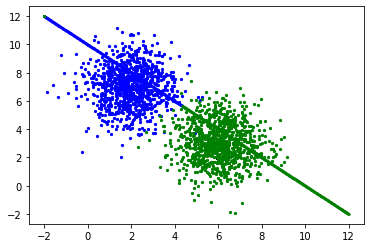

In [10]:
x1 = np.linspace(-2,12,1000)
x2 = np.linspace(12,-2,1000)
test_x = np.vstack((x1,x2)).T

test_y = model.predict(test_x)

# plot the train data
plt.scatter(train_data[np.argwhere(train_label==0),0],train_data[np.argwhere(train_label==0),1],s=5,c='b')
plt.scatter(train_data[np.argwhere(train_label==1),0],train_data[np.argwhere(train_label==1),1],s=5,c='g')
#plot line
plt.scatter(test_x[np.argwhere(test_y<0.5),0],test_x[np.argwhere(test_y<0.5),1],s=2,c='b')
plt.scatter(test_x[np.argwhere(test_y>=0.5),0],test_x[np.argwhere(test_y>=0.5),1],s=2,c='g')